<h2> Не лесом единым... </h2>

Мы уже познакомились с решающими деревьями и случайными лесами. И это действительно мощный инструмент решения ML задач, но далеко не универсальный.

In [1]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
%matplotlib inline

Попробуем применить решающее дерево для простой задачи регрессии, где X = y.

In [2]:
X_origin = np.linspace(0, 100, 21)
y_origin = X_origin

In [3]:
X_origin

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

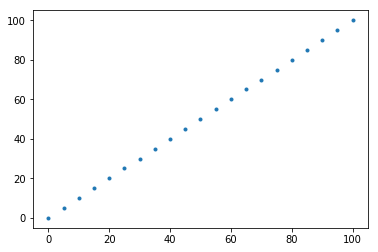

In [4]:
plt.plot(X_origin, y_origin, '.')

Этот график все наши данные. Теперь надо разбить их как мы умеем на обучающий и проверочный сет. Всего 21 пример, 15 для обучения, 6 для проверки.

In [5]:
X_train = X_origin[:15].reshape(-1, 1)
y_train = y_origin[:15]
X_valid = X_origin[15:].reshape(-1, 1)
y_valid = y_origin[15:]

In [6]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
predicted = dt.predict(X_valid)

Дерево обучили, проверочный сет предсказали, теперь посмотрим как выглядит наше решение на графике.

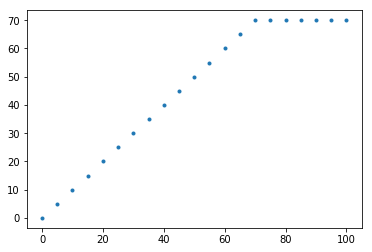

In [7]:
plt.plot( X_origin, np.concatenate((y_train,  predicted)) , '.')

Ответ не особенно привлекательный. Почему так произошло? Для каждой обучающей точки, дерево построило разбиение. При этом максимальное значение, которое видело дерево на обучении было равно 70. Такое правило и было сконструированно: "Если значение X больше 69.9, то y = 70". А все наши проверочные примеры попали под это правило, ответ для каждого из них - 70.

<b>Деревья не умеют экстраполировать.</b>

Теперь попробуем решить задачу классификации при помощи решающего дерева.

Разделяющая поверхность для двух классов, как и была X = y

In [8]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

In [9]:
X, y = form_linearly_separable_data()

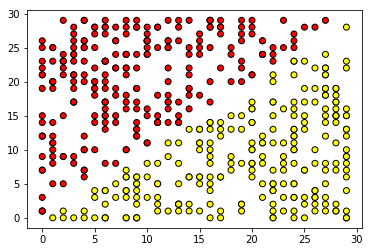

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black', )

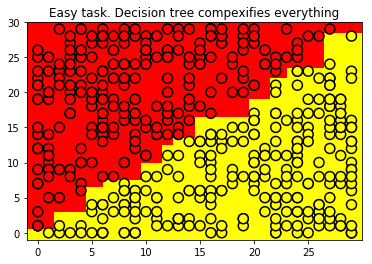

In [11]:
tree = DecisionTreeClassifier(random_state=2, max_depth=20).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

<b>Деревья могут выстраивать излишне сложные конструкции</b>

Существует другой тип моделей - линейные модели, сейчас про них и узнаем

Рассмотрим пример задачи классификации, мы решаем пойти на ярмарку или нет. У нас есть некоторые исходные параметры. Погода (Дождь-Солнечно), пойдёт ли друг за компанию (Да-Нет), можно ли добраться туда на автобусе (Да-Нет).

В данном случае у нас есть 3 входные переменные, а на выходе мы получаем решение(Пойду - Не пойду), а функция принятия решения у нас в голове. 

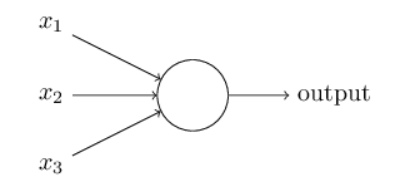

In [12]:
Image(filename='img/l3_1.png')

Но как получить из входных параметров решение? Для нас каждый из изначальных параметров имеет своё значение, в компании с другом мы готовы идти куда угодно, а без него гулять только в хорошую погоду и на транспорте. Так вот у каждого параметра есть своё значение для нас - <b>Вес</b>, обозначим его как W. Получается при принятии решения мы получаем формулу 

<center>$x_1 * w_1 + x_2 * w_2 + x_3 * w_3$</center>

А решение у нас может быть только "пойду(1) - не пойду(0)". Мы идём если наше желание выше нашей лени (порога).

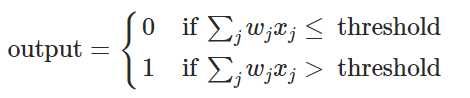

In [13]:
Image(filename='img/l3_2.png')

Попробуем на примере. Компания для нас важна, вес = 4, погода и транспорт не очень, вес = 2. $w_1 = 4, w_2 = 2, w_3 = 2$. Порог нашей лени установим = 3

Друг идёт, плохая погода, автобус не ходит = 4\*1 + 2\*0 + 2*0 \> 3 = идём на ярмарку

Друг не идёт, плохая погода, автобус ходит = 4\*0 + 2\*0 + 2*1 \< 3 = не идём на ярмарку

Друг не идёт, плохая хорошая, автобус ходит = 4\*0 + 2\*1 + 2*1 \> 3 = идём на ярмарку

При этом повлиять на входные параметры X (друга, автобус, погоду) мы не можем, но можем изменить наше отношение к ним W и порог нашей лени. Если порог сделать 0, мы пойдём на ярмарку в любом случае. 

Чтобы чуть упростить запись, перенесём его в левую часть уравнения и будем сравнивать с нулём


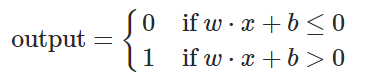

In [14]:
Image(filename='img/l3_3.png')

Формулу так же можно записать

<center>$output = sign(w*x + b) $</center>

График нашего решения выглядит примерно таким образом. А сама функция имеющий такой вид называется <b>Перцептрон</b>

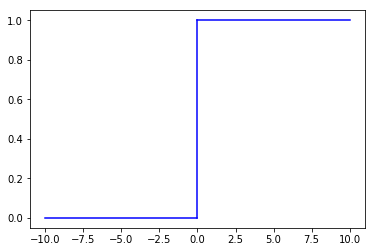

In [15]:
plt.plot([-10,0], [0,0], color='b')
plt.plot([0,10], [1,1], color='b')
plt.plot([0,0], [0,1], color='b')
plt.show()

Обучение нашего алгоритма, в случае нашей модели, будет поиск весов W. Но судя из графика нашей функции, при большинстве изменений веса W ответ алгоритма не изменится. 

$x_1 * w_1 + x_2 * w_2 + x_3 * w_3$<br>
$1 * 4 + 0 * 2 + 0 * 2 > 3 $ Изменяем вес W1<br>
$1 * 3.99 + 0 * 2 + 0 * 2 > 3 $<br>
$1 * 3.98 + 0 * 2 + 0 * 2 > 3 $

Теперь представим что нам надо отличить цифры написанные от руки. Вначале надо понять как выглядит изображение для машины.

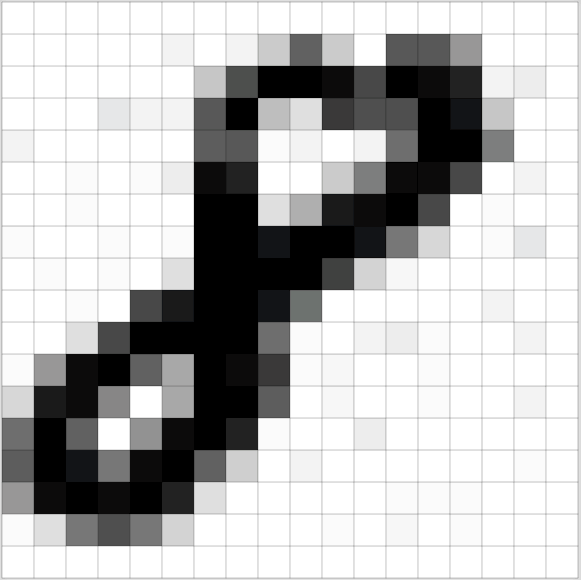

In [17]:
Image(filename='img/l3_4.gif')

Данное изображение очень низкого разрешения 28х28 пикселей. Но каждый их этих пикселей будет входным значением для нашего линейного алгоритма. Соответсвенно входных значений у нас 28 * 28 = 784. И у нас будет вес для каждого из этих входных значений. И мы хотели бы видеть, как изменение веса для каждого пикселя влияет на наш конечный ответ. 

Нам хочется иметь функцию, которая будет показывать изменение при каждом изменении входных параметров, но одновременно сохраняет свойства перцептрона

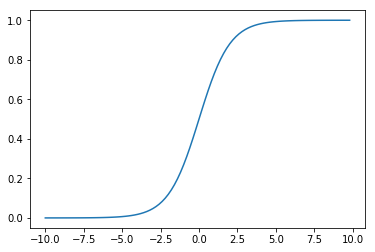

In [18]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+np.exp(-item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

<b>Сигмоида</b> - функция принимающая значения от 0 до 1 и не имеющая разрыва.

$\phi(z) = \dfrac{1}{1 + e^{-z}}$


где $z$ <br>


$z = b + w_1x_1 + w_2x_2 + ... + w_nx_n$<br>

При очень большом значении параметра $z$ сигмоида принимает значение близкое к 1, при отрицательном значении близкое к 0, а в окрестностях $z = 0$ плавно меняет своё значение от 0 до 1. Большим плюсом является то, что интерпретировать значение можно как вероятность принадлежности к какому то классу.

Теперь мы знаем что делать со всеми входящими весами, как предсказать ответ. Надо узнать что делать с этим ответом после. Для этого введём функцию стоимости (cost function).

Мы уже имели дело с функцией ошибки MAE <br>
<h2><center>$ L = \frac{1}{n}\sum| predict - actual | $ </center></h2> <br>
и функцией MSE<br>
<h2><center>$ L = \frac{1}{n}\sum( predict - actual )^2 $ </center></h2> <br>

Пока попробуем воспользоваться MSE. Проще всего проиллюстрировать её работу на простом примере. 

У нас есть 3 точки с координатами (1,1),(2,2),(3,3). Оригинальная функция распределения $y = 1*x$

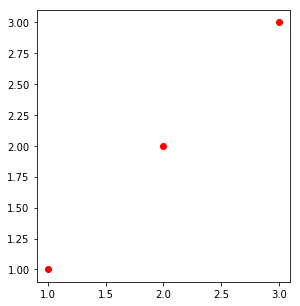

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
# bx = fig.add_subplot(1, 2, 2)
ax.plot([1,2,3], [1,2,3], 'o', color= 'r')
# ax.plot([0,1,2,3], [0,1,2,3], )
# bx.plot([0], [0], 'o', color= 'r' )


Попробуем выстроить гипотезу, поскольку машина не может сразу догадаться о нужной функции. Гипотезу будем строить из пространства z = w * x.

Начнём с параметра $w = 0$. Т.е наша гипотеза будет иметь вид $z = 0 * x$. И сразу же будем считать ошибку MSE.

Text(0.5,0,'w')

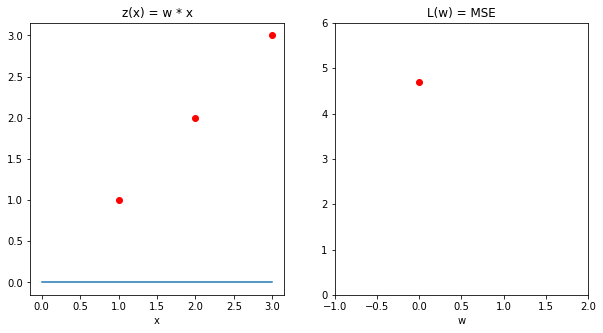

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

ax.plot([1,2,3], [1,2,3], 'o', color= 'r')
ax.plot([0,1,2,3], [0,0,0,0], )
ax.set_title('z(x) = w * x')
ax.set_xlabel('x')

aw = fig.add_subplot(1, 2, 2)
aw.set_autoscale_on(False)
aw.set_xlim(-1, 2)
aw.set_ylim(0, 6)
aw.plot([0], [4.7], 'o', color= 'r' )
aw.set_title('L(w) = MSE')
aw.set_xlabel('w')


При $z(x) = 0 * x$ Ошибка имеет следующий вид

<center>$L(w) = \frac{1}{3} ((1 - 0)^2 + (2- 0)^2 + (3 - 0)^2) = 4.7$</center>

Поменяем параметр на $w = 0.5$

Text(0.5,0,'w')

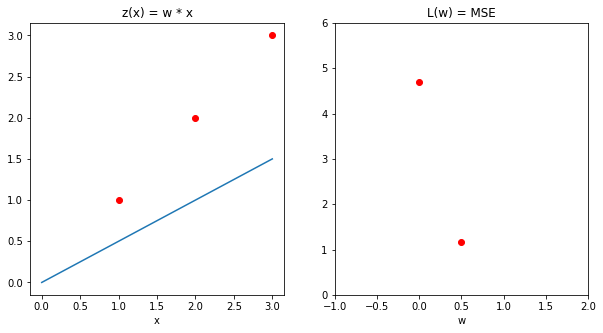

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

ax.plot([1,2,3], [1,2,3], 'o', color= 'r')
ax.plot([0,1,2,3], [0,0.5,1,1.5], )
ax.set_title('z(x) = w * x')
ax.set_xlabel('x')

aw = fig.add_subplot(1, 2, 2)
aw.set_autoscale_on(False)
aw.set_xlim(-1, 2)
aw.set_ylim(0, 6)
aw.plot([0, 0.5, ], [4.7, 1.17], 'o', color= 'r' )
aw.set_title('L(w) = MSE')
aw.set_xlabel('w')


При $z(x) = 0.5 * x$ Ошибка имеет следующий вид

<center>$L(w) = \frac{1}{3} ((1 - 0.5)^2 + (2- 1)^2 + (3 - 1.5)^2) = 1.17 $</center>

Поменяем параметр на $w = 1$

Text(0.5,0,'w')

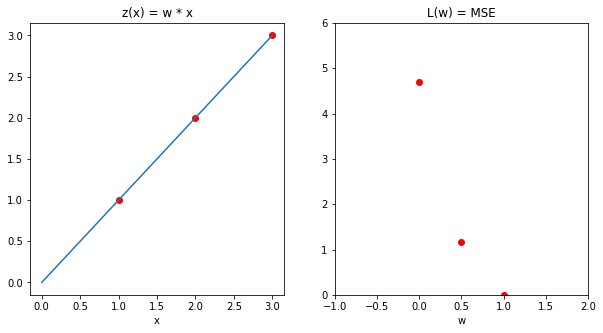

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

ax.plot([1,2,3], [1,2,3], 'o', color= 'r')
ax.plot([0,1,2,3], [0,1,2,3], )
ax.set_title('z(x) = w * x')
ax.set_xlabel('x')

aw = fig.add_subplot(1, 2, 2)
aw.set_autoscale_on(False)
aw.set_xlim(-1, 2)
aw.set_ylim(0, 6)
aw.plot([0, 0.5, 1], [4.7, 1.17, 0], 'o', color= 'r' )
aw.set_title('L(w) = MSE')
aw.set_xlabel('w')


При $z(x) = 1 * x$ Ошибка имеет следующий вид

<center>$L(w) = (1 - 1)^2 + (2- 2)^2 + (3 - 3)^2 = 0 $</center>

Пример может показаться слишком лёгким. ПОявляется вопрос, зачем вообще всё это делать при помощи изощрённых алгоритмов, если можно сразу же понять какая функция нужна.

Но вспомним, что мы упростили нашу изначальную функцию $z = w*x +b$ до  $z = w*x$. Если бы мы этого не сделали, график нашей функции выглядел бы вот так

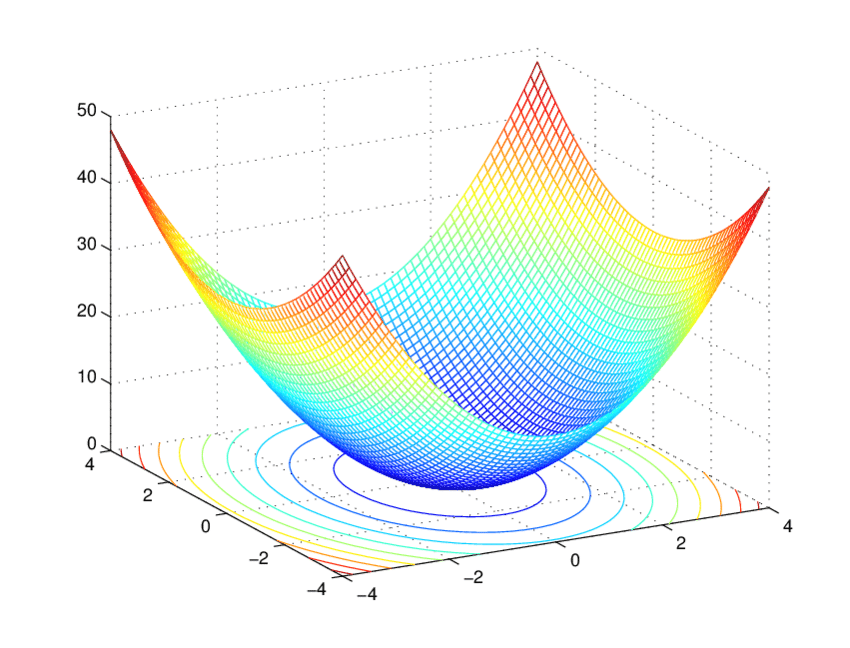

In [23]:
Image(filename='img/l3_5.png')

Но и эта функция слишком упрощена. В жизни, у нас будет не 1 параметр, а десятки (как в примере со стоимостью квартиры) или  сотни (как в примере с определением рукописного числа) или миллионы как в современных задачах ML.

Теперь у нас есть полный набор знаний для того чтобы пройти путь от гипотезы до ошибки.

<center>Гипотеза: $z(x) = w_1* x_1 + b$</center>
<center>Параметры: $w_1, b$</center>
<center>Функция ошибки: $L(w,b) = \frac{1}{n}\sum( predict - actual )^2 $</center>
<center>Цель: $minimize L(w,b)$</center>

Теперь только стоит вопрос о том, как же минимизировать нашу ошибку $L$. Всё что у нас есть в распоряжении это параметры $W$ и $b$. В примере мы перебирали значения $W$ от 0 до 1, но у нас была какая то изначальная стратегия и мы её придерживались. Когда параметр не 1 (как в примере), а их 10000, так ловко не получится. Так как же нам оптимизировать $W$ ? 

1) Мы можем попробовать выбирать W случайным образом и считать ошибку для каждого значения, запоминая лучшее.

Испытывать подходы я буду на задаче определения рукописного числа.

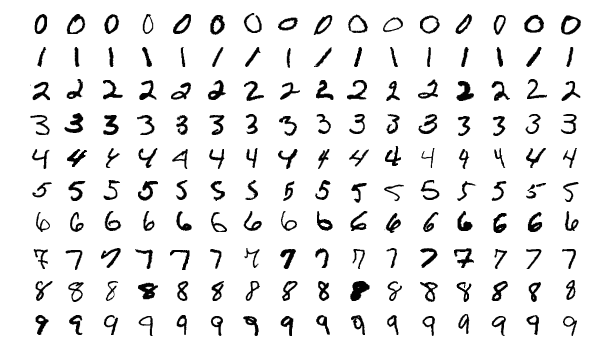

In [26]:
Image(filename='img/l3_6.png')

(Тут без исходного кода)<br>
Сделав 1000 повторений случайного выбора W, у меня получилось достичь точности в 15.5%. Что всё же лучше, чем если бы мы просто делали предсказание наугад (наша точность была бы 10%)

2) Можем выбрать произвольный $W$ и на каждом шаге изменять его на $\delta W $ и сохранять наше изменение только если ошибка уменьшилась

Сделав 1000 повторений подобного алгоритма удалось достичь точности в 21.4%

Лучше чем при случайном переборе. Главная идея, которую мы можем извлечь, что не столь важно откуда мы начинаем, главное что мы должны двигаться в сторону уменьшения ошибки.

И как выяснилось в математике есть идея, которая как раз подходит нам для этой задачи - производная.<br>
Перед 3-м пунктом вспомним, что же такое производная

Text(0,0.5,'f(x)')

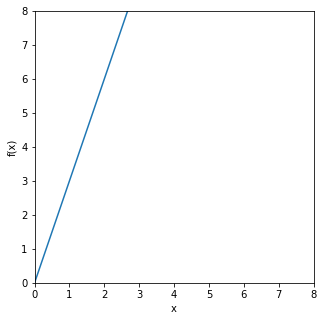

In [27]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot([0,1,2,3], [0,3,6,9])
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

На графике $f(x) = 3*x$

при $x = 2$, $f(x) = 6$ <br>
сделаем крошечный шаг по оси $х$, допусти в $0.001$ <br>
при $x' = 2.001$, $f'(x) = 6.003$<br>
Теперь найдём насколько изменилось значение нашей функции f(x) при таком шаге<br>
$6.003 - 6 = 0.003$<br>
Если разделим это значение, на сам шаг аргумента х, то получим скорость роста нашей функции в точке x = 2<br>
$0.003 / 0.001 = 3$<br>
Это значение и есть производная. Часто говорят, что производная характеризует скорость изменения функции в точке.



Посмотрим на другой пример, функцию $f(x) = x^2$

Text(0,0.5,'f(x)')

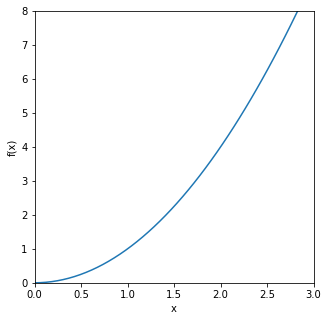

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
x_curve = np.linspace(start=0, stop=3, num=50)
ax.plot(x_curve, (lambda x: x*x)(x_curve),)
ax.set_xlim(0, 3)
ax.set_ylim(0, 8)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

при $x = 2$, $f(x) = 4$ <br>
сделаем крошечный шаг по оси $х$, допусти в $0.001$ <br>
при $x' = 2.001$, $f'(x) = 4.004$<br>
Теперь найдём насколько изменилось значение нашей функции f(x) при таком шаге<br>
$4.004 - 4 = 0.004$<br>
Если разделим это значение, на сам шаг аргумента х, то получим скорость роста нашей функции в точке x = 2<br>
$0.004 / 0.001 = 4$<br>

при $x = 3$, $f(x) = 9$ <br>
сделаем крошечный шаг по оси $х$, допусти в $0.001$ <br>
при $x' = 3.001$, $f'(x) = 9.006$<br>
Теперь найдём насколько изменилось значение нашей функции f(x) при таком шаге<br>
$9.006 - 9 = 0.006$<br>
Если разделим это значение, на сам шаг аргумента х, то получим скорость роста нашей функции в точке x = 3<br>
$0.006 / 0.001 = 6$<br>

Даже для одной функции производная в разных точках может отличаться. 

Формальная нотация выглядит следующим образом: ${\frac{d}{dx}}f(x)$

Для $f(x) = x^2$, ${\frac{d}{dx}}f(x) = 2x$

Для всех стандартных функций значений производных можно найти в соответствующей таблице.

Ещё одно представление производной:

<center>$\frac{df(x)}{dx} = \lim_{h\ \to 0} \frac{f(x + h) - f(x)}{h}$</center>

Которая описывает наш алгоритм в самом начале. Имеем значение функции ($f(x)$), меняем его на 0.001 ($h$) и смотрим на изменения.


Вернёмся в задаче поиска веса W

3) Используем производную, она говорит нам как поменяется наша целевая функция (ошибка), при изменении входных параметров (w, b). По сути, мы находясь в любой точке функции, можем определить куда надо сделать шаг, чтобы ошибка уменьшилась

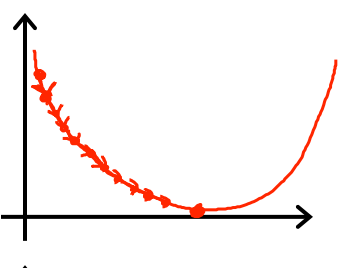

In [29]:
Image(filename='img/l3_7.png')

Формально это можно описать формулой

<h3><center> $w_1 = w_1 - \alpha* \frac{d}{dw_1}L(w_1) $ </center></h3>

Мы имеем изначальные параметры W, на первом этапе мы задаём их случайно, или ставим все равные 0. Затем считаем производную нашей функции ошибки, которая показывает как изменится ошибка, при изменении параметра W. Эту производную умножаем на параметр $\alpha$ (Сейчас будем считать его равным 0.0001). 

Данные процесс мы повторяем много раз.<br>
??????<br>
PROFIT!

Откуда и зачем у нас появился параметр $\alpha$ ? Его мы умножаем на производную, а производная характеризует скорость изменения функции, по этому мы скорость умножаем на маленькое число, чтобы аккуратно спускаться к минимуму функции. В противном случа может быть подобная картина.


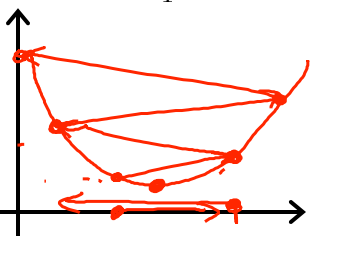

In [30]:
Image(filename='img/l3_8.png')

Скорость изменения функции увеличивается каждый раз и мы отдаляемся от минимального значения, а не движемся к нему. 

Теперь у нас есть все знания о том, как работает линейная модель.

Мы умеем при помощи весов (W) находить ошибку (L). Это называется Forward pass.<br>
Мы умеем при наличии ошибки (L) изменять веса (W). Это называется Backward pass.


Опробуем наши знания на простом примере.

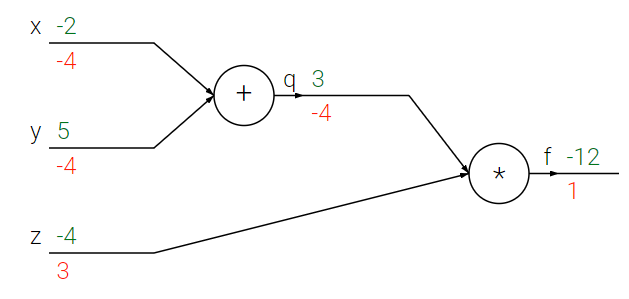

In [31]:
Image(filename='img/l3_9.png')